In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import math
from scipy.ndimage.filters import gaussian_filter

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Constants and functions

In [3]:
G=6.67408*1e-11
# [m**3]
def volume_sphere(r):
    return 4./3*math.pi*r**3
# delta_density [g/cm**3] -> mass [kg]
def delta_mass_sphere(r, delta_density):
    return 1000.*delta_density*volume_sphere(r)
# [мГал]
def delta_grav(delta_mass, x,y,z):
    return (100.*1000)*G*delta_mass*z/np.power(x**2 + y**2 + z**2, 1.5)

def raster_gamma_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

## Synthetic Density Model

In [4]:
L = 200
Z = 100
x = np.linspace(-L,L,2*L+1)
y = np.linspace(-L,L,2*L+1)
z = -np.arange(1,Z+1)
(xx,yy,zz) = np.meshgrid(x,y,z)

In [5]:
def gaussian(x, y, z, std, amplitude):
    r2 = x**2 + y**2 + z**2
    return amplitude*np.exp(-r2/std**2)

X0 = np.array([350,375,400,450,500,550,600,625,650])/2
Y0 = np.array(len(X0)*[0])
Z0 = np.array([50,0,50,25,0+50,25,50,0,50])/2
V0 = [-1,-1,1,-1,-1,-1,1,-1,-1]

da_density = xr.DataArray(np.zeros(zz.shape), coords={'x': x, 'y': y, 'z': z}, dims=['x','y','z'])
for (x0,y0,z0,v0) in zip(X0,Y0,Z0,V0):
    da_density.values += gaussian(xx+x0-250, yy+y0, zz+z0, 20, v0)
da_density.values = da_density.transpose('y','x','z').values
da_density['x'] = -da_density.x

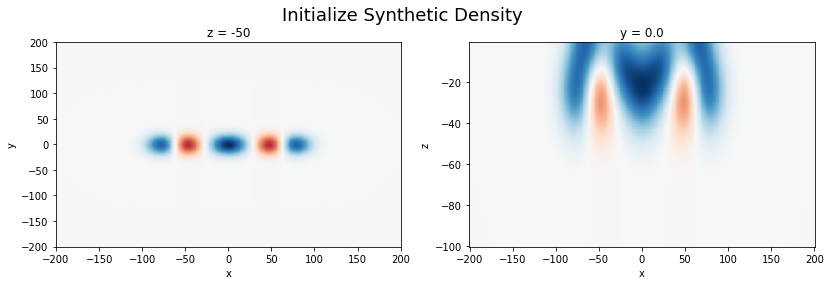

In [6]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 1)
da_density.sel(z=-50,method='nearest').T.plot(ax=ax, add_colorbar=False)

ax = fig.add_subplot(1, 2, 2)
da_density.sel(y=0).T.plot(ax=ax, add_colorbar=False)

plt.suptitle('Initialize Synthetic Density', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

In [7]:
# gaussian filtering
da_fdensity = raster_gamma_range(da_density, 10,11)

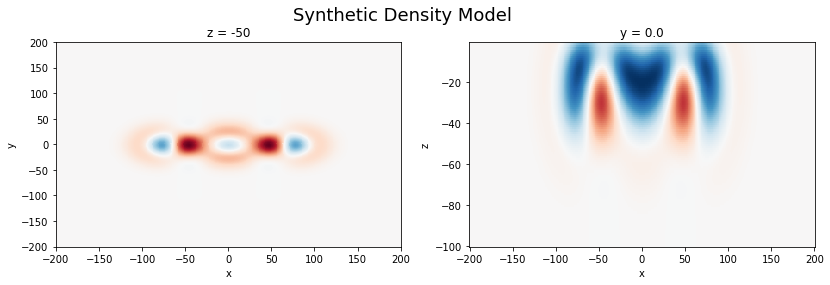

In [8]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 1)
da_fdensity.sel(z=-50,method='nearest').T.plot(ax=ax, add_colorbar=False)

ax = fig.add_subplot(1, 2, 2)
da_fdensity.sel(y=0).T.plot(ax=ax, add_colorbar=False)

plt.suptitle('Synthetic Density Model', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

## Gravity Forward Model

In [9]:
def _delta_grav(val, dx, dy, dz):
    return delta_grav(delta_mass_sphere(.5,val), dx, dy, -dz)
da_gravity = xr.apply_ufunc(_delta_grav, da_fdensity, x+da_fdensity.x, y-da_fdensity.y, da_fdensity.z).sel(z=0, method='nearest')

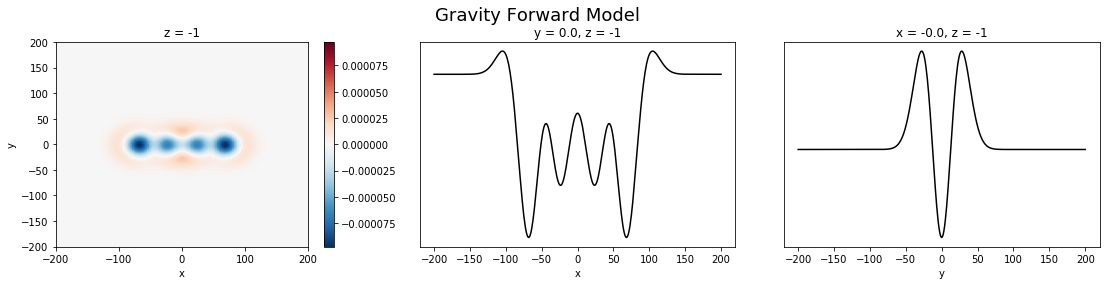

In [10]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(1, 3, 1)
da_gravity.T.plot(ax=ax)

ax = fig.add_subplot(1, 3, 2)
da_gravity.sel(y=0).plot(ax=ax, c='black')
plt.gca().get_yaxis().set_ticks([])

ax = fig.add_subplot(1, 3, 3)
da_gravity.sel(x=0).plot(ax=ax, c='black')
plt.gca().get_yaxis().set_ticks([])

plt.suptitle('Gravity Forward Model', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

## Circular Hough Transform [Focal Average]

In [11]:
def unit_circle_2d(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt( A[:,None] + A)
    if r <= 2:
        return ((dists-r)<=0).astype(int)
    return ((dists-r)<=0.5).astype(int)

In [12]:
from scipy.signal import convolve2d

rs = np.arange(72)
means = []
for r in rs:
    print (r, end=' ')
    mask = unit_circle_2d(r)
    mask[1:-1,1:-1] -= unit_circle_2d(r-1)
    mean = convolve2d(da_gravity, mask/np.sum(mask), mode='same')
    means.append(mean)
means = np.array(means)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 

In [13]:
dx = da_gravity.x.diff('x').values[0]
da_gravity_focal = xr.DataArray(means, coords=[dx*rs/np.sqrt(2),x,y], dims=['z','x','y'])

## Plot the models

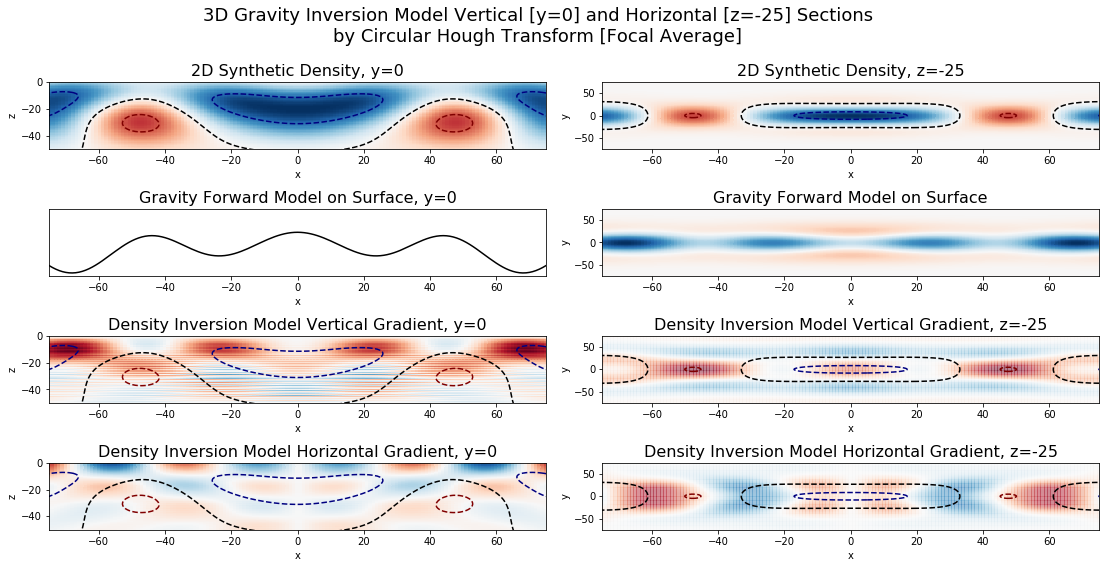

In [17]:
xsize = 75
zsize = 50
levels=[-5e-2,0,4e-2]
colors=['navy','black','maroon']

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(4, 2, 1)
da_fdensity.sel(y=0).T.plot(ax=ax, add_colorbar=False)
da_fdensity.sel(y=0).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('2D Synthetic Density, y=0', fontsize=16)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 2, 3)
da_gravity.sel(y=0).plot(ax=ax, c='black')
ax.set_title('Gravity Forward Model on Surface, y=0', fontsize=16)
ax.get_yaxis().set_ticks([])
ax.set_xlim([-xsize, xsize])

ax = fig.add_subplot(4, 2, 5)
# vertical gradient
grd = da_gravity_focal.sel(y=0).diff('z')
grd.plot(ax=ax, add_colorbar=False)
da_fdensity.T.sel(y=0).plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model Vertical Gradient, y=0', fontsize=16)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 2, 7)
# radial gradient (from x gradient)
grd = da_gravity_focal.sel(y=0).diff('x')
grd.values[:,:200] = -grd.values[:,:200]
grd.plot(ax=ax, add_colorbar=False)
da_fdensity.sel(y=0).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model Horizontal Gradient, y=0', fontsize=16)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 2, 2)
da_fdensity.T.sel(z=-25).plot(ax=ax, add_colorbar=False)
da_fdensity.T.sel(z=-25).plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('2D Synthetic Density, z=-25', fontsize=16)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 2, 4)
da_gravity.T.plot(ax=ax, add_colorbar=False)
ax.set_title('Gravity Forward Model on Surface', fontsize=16)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 2, 6)
# vertical gradient
grd = da_gravity_focal.diff('z')
grd.sel(z=-25,method='nearest').T.plot(ax=ax, alpha=0.2, add_colorbar=False)
da_fdensity.sel(z=-25).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model Vertical Gradient, z=-25', fontsize=16)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 2, 8)
# radial gradient (from x gradient)
grd = da_gravity_focal.sel(z=-25, method='nearest').diff('x').T
grd.values[:,:200] = -grd.values[:,:200]
grd.plot(ax=ax, alpha=0.2, add_colorbar=False)
da_fdensity.sel(z=-25).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model Horizontal Gradient, z=-25', fontsize=16)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

plt.suptitle('3D Gravity Inversion Model Vertical [y=0] and Horizontal [z=-25] Sections\nby Circular Hough Transform [Focal Average]', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].jpg', quality=95)
plt.show()